## Skull Stripping Prediction T1w

### 1. Import libraries

In [17]:
import os
import numpy as np
import torch
import torchio as tio
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Ignore : warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

In [2]:
__file__ = 'Skull-Stripping-T1_prediction.ipynb'
BASE_DIR = Path(__file__).resolve().parent
PARENT_DIR = BASE_DIR.parent
lib_path = PARENT_DIR / "Skull_Stripping"

In [3]:
import sys
sys.path.insert(0,str(lib_path)) #
from lib.models import ResidualUNET3D
from lib.runners import *
from lib.data import *
from lib.utils import *

### 2. Récupération de l'architechture du model T1w

In [4]:
patch_size = 32
overlap_size = 16
batch_size = 8

device = "cuda:0"
device = torch.device(device)

In [5]:
model = ResidualUNET3D(in_channels=1, out_channels=1, optional_skip=True)
model = torch.nn.DataParallel(model).to(device)
model_name = "ResidualUNET3D_Adam_10_3.pth"

### 2. Chargement du model T1w

In [6]:
__file__ = 'tumor_classifier.ipynb'
BASE_DIR = Path(__file__).resolve().parent
PARENT_BASE_DIR = BASE_DIR.parent

In [7]:
path_model = PARENT_BASE_DIR / "Skull_Stripping" / "models_skull-stripping" / model_name
path_model = str(path_model)

In [8]:
model.load_state_dict(torch.load(path_model))
model.eval()

DataParallel(
  (module): ResidualUNET3D(
    (conv1_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv1_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (conv1_short): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (residual_block1): ResidualBlock3D(
      (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act2): LeakyReLU(negative_slope=0.2, inplace=True)
      (drop1): Dropout(p=0.2, inplace=False)
      (con

In [9]:
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {total_parameters}")

Number of parameters in the model: 35379008


### 3. Recupération des IRM

In [10]:
path_histogram_landmarks = PARENT_BASE_DIR / "Skull_Stripping" / "ressources" / "NFBS_histogram_landmarks.npy"
path_histogram_landmarks = str(path_histogram_landmarks)

valid_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.HistogramStandardization({'mri': np.load(path_histogram_landmarks)}),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean)
    ])

In [11]:
# Récupération des images
path_mri_t1w = []
for i in range (1,5):
    path_mri_t1w.append(str(BASE_DIR / "Skull-Stripping_prediction" / "T1" / str(i) /"image.nii.gz"))
          
path_mri_t2w = []
for i in range (1,5):
    path_mri_t2w.append(str(BASE_DIR / "Skull-Stripping_prediction" / "T2" / str(i) /"image.nii.gz"))
                        
path_mri_infant = []
for i in range (1,5):
    path_mri_infant.append(str(BASE_DIR / "Skull-Stripping_prediction" / "INFANT" / str(i) /"image.nii.gz"))

path_mri_flair = []
for i in range (1,5):
    path_mri_flair.append(str(BASE_DIR / "Skull-Stripping_prediction" / "FLAIR" / str(i) /"image.nii.gz"))

In [12]:
# Récupération des masks pour l'évaluation
path_mri_t1w_mask = []
for i in range (1,5):
    path_mri_t1w_mask.append(str(BASE_DIR / "Skull-Stripping_prediction" / "T1" / str(i) /"mask.nii.gz"))
          
path_mri_t2w_mask = []
for i in range (1,5):
    path_mri_t2w_mask.append(str(BASE_DIR / "Skull-Stripping_prediction" / "T2" / str(i) /"mask.nii.gz"))
                        
path_mri_infant_mask = []
for i in range (1,5):
    path_mri_infant_mask.append(str(BASE_DIR / "Skull-Stripping_prediction" / "INFANT" / str(i) /"mask.nii.gz"))

path_mri_flair_mask = []
for i in range (1,5):
    path_mri_flair_mask.append(str(BASE_DIR / "Skull-Stripping_prediction" / "FLAIR" / str(i) /"mask.nii.gz"))

In [13]:
predict_images = [path_mri_t1w[0], path_mri_t1w[1], path_mri_t2w[0], path_mri_flair[0], path_mri_infant[0]]
saved_imgs = []

In [14]:
def shape(path) :
    nii_img = nib.load(path)
    nii_img_data = nii_img.get_fdata()
    np_array_img = np.array(nii_img_data)
    return np_array_img.shape

In [15]:
print(f"Shape of the MRI T1w: {shape(predict_images[0])}")
print(f"Shape of the MRI T2w: {shape(predict_images[2])}")
print(f"Shape of the MRI FLAIR: {shape(predict_images[3])}")
print(f"Shape of the MRI INFANT: {shape(predict_images[4])}")

Shape of the MRI T1w: (256, 256, 256)
Shape of the MRI T2w: (256, 256, 130)
Shape of the MRI FLAIR: (432, 512, 23)
Shape of the MRI INFANT: (256, 256, 256)


### 4. Prediction

Image: /home/allan/Licence3_Informatique/LIFPRO/Prediction/Skull-Stripping_prediction/T1/1/image.nii.gz


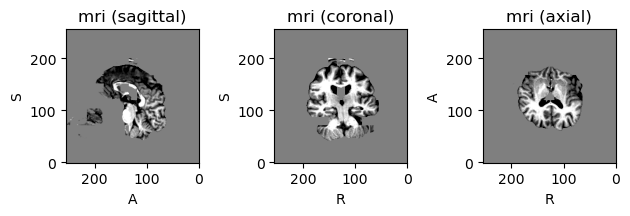

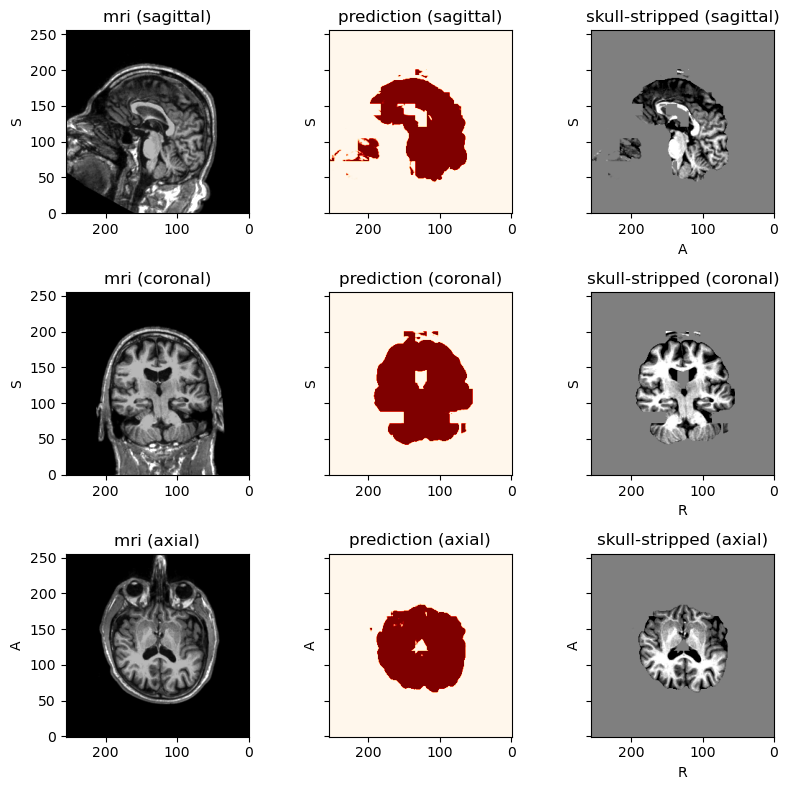

Image: /home/allan/Licence3_Informatique/LIFPRO/Prediction/Skull-Stripping_prediction/T1/2/image.nii.gz


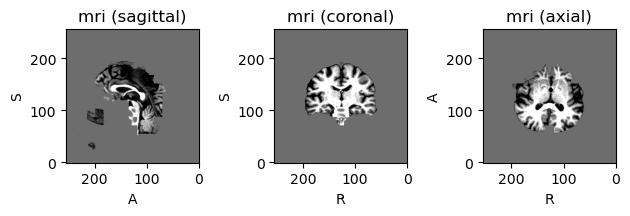

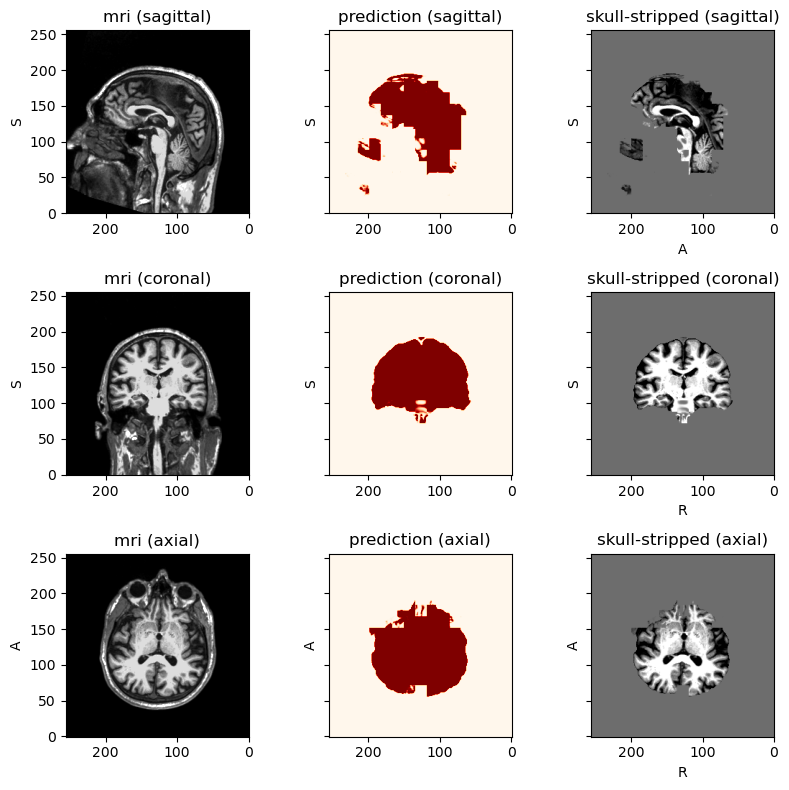

Image: /home/allan/Licence3_Informatique/LIFPRO/Prediction/Skull-Stripping_prediction/T2/1/image.nii.gz


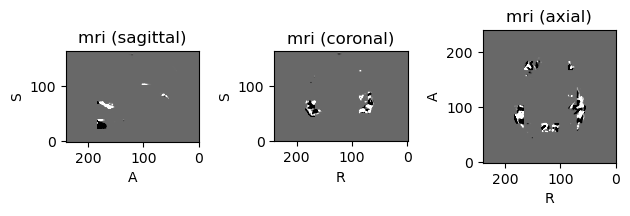

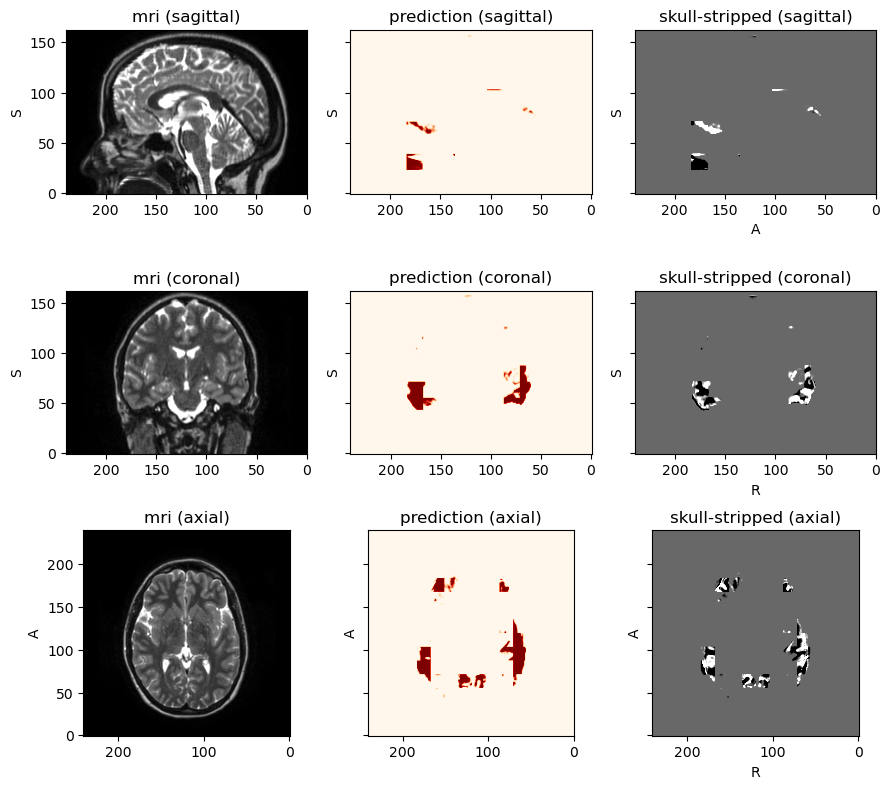

Image: /home/allan/Licence3_Informatique/LIFPRO/Prediction/Skull-Stripping_prediction/FLAIR/1/image.nii.gz


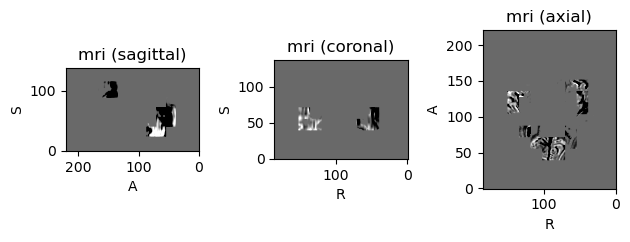

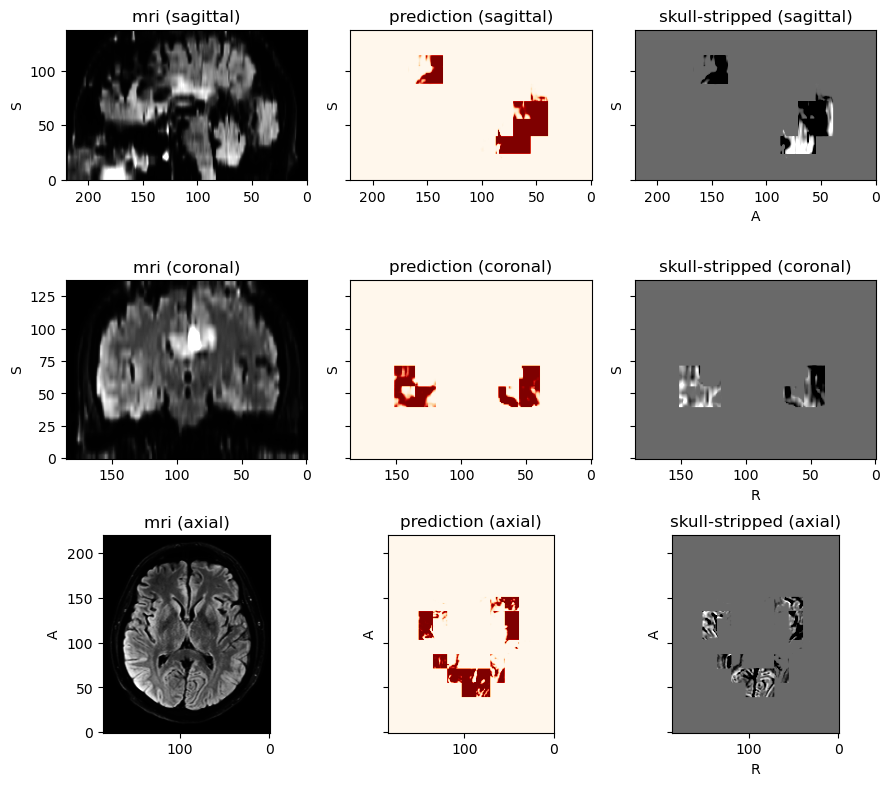

Image: /home/allan/Licence3_Informatique/LIFPRO/Prediction/Skull-Stripping_prediction/INFANT/1/image.nii.gz


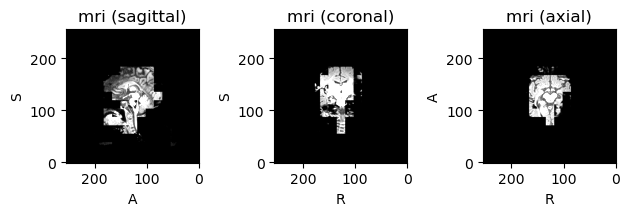

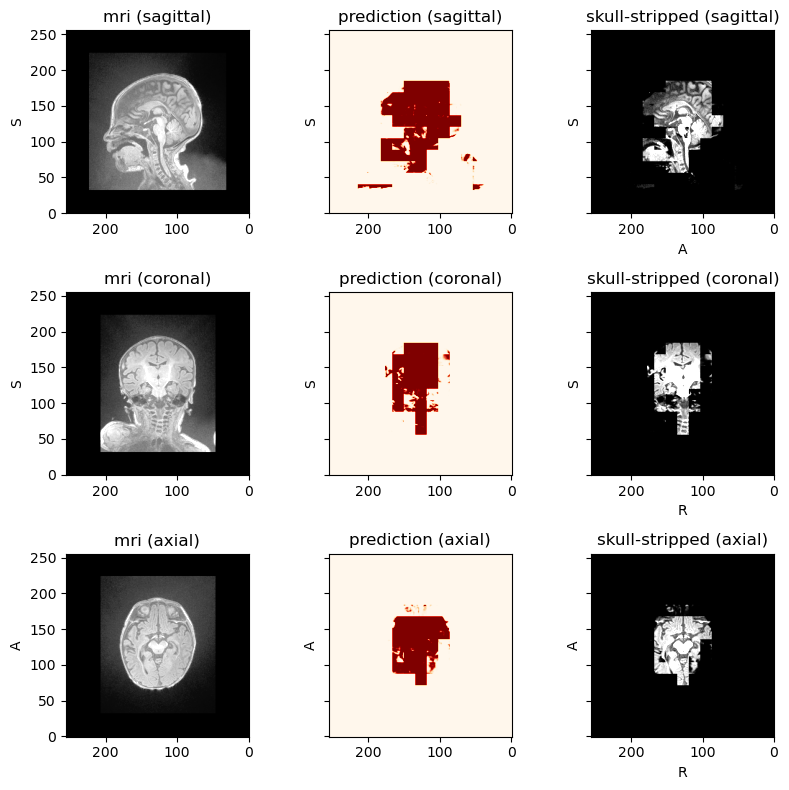

In [18]:
for image in predict_images:
  print(f"Image: {image}")
  save_path = image.split('.')[0] + '_skull_stripped.nii.gz'
  saved_imgs.append(save_path)

  original, stripped, mask = infer(image, 
                                   save_path, model, 
                                   patch_size=patch_size, 
                                   overlap=overlap_size, 
                                   batch_size=batch_size, 
                                   device=device, 
                                   visualize=True, 
                                   return_tensors=True, 
                                   transforms=valid_transforms)

  subject = tio.Subject(mri=tio.ScalarImage(tensor=original))
  subject.add_image(tio.ScalarImage(tensor=mask), 'prediction')
  subject.add_image(tio.ScalarImage(tensor=stripped), 'skull-stripped')
  subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'OrRd'})

On peut apercevoir que le model ne marche que pour les T1, et pas pour les autres. Il faut donc créer un model pour chaque séquence d'IRM